## ARIMA multi-step forecasting model

Temas tratados: 

1. Crear y analizar autocorrelacion de las variables
2. Usar el analisis de autocorrelacion para configurar un modelo de autoregresion
3. Desarrollo y evaluacion de un modelo de  autocorrelacion usado para pronosticos de una semana adelante  

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [2]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
        # calculate overall RMSE
        s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [3]:
def evaluate_model(model_func, train, test):
# history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = model_func(history)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    predictions = array(predictions)
    # evaluate predictions days for each week
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores
    

In [48]:
def to_series(data):
    # extract just the total power from each week
    series = [week[:, 0] for week in data]
    # flatten into a single series
    series = array(series).flatten()
    return series

In [4]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

In [7]:
dataset = read_csv('household_power_consumption_days.csv', header=0,
infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
train, test = split_dataset(dataset.values)
# convert training data into a series
series = to_series(train)

**Se mide la autocorrelacion entre series de tiempo, comparando la misma semana un año atras, lo que se representa en el codigo como lags = 365 **

In [39]:
dataset.head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.934
2006-12-17,3390.460,226.006,345725.30,14398.6,2033.0,4187.0,13341.0,36946.668
2006-12-18,2203.826,161.792,347373.62,9247.2,1063.0,2621.0,14018.0,19028.434
2006-12-19,1666.194,150.942,348479.00,7094.0,839.0,7602.0,6197.0,13131.900
2006-12-20,2225.748,160.998,348923.62,9313.0,0.0,2648.0,14063.0,20384.800
2006-12-21,1723.288,144.434,347096.40,7266.4,1765.0,2692.0,10456.0,13808.467
2006-12-22,2341.338,186.906,347305.75,9897.0,3151.0,350.0,11131.0,24390.300
2006-12-23,4773.386,221.470,345795.94,20200.4,2669.0,425.0,14726.0,61736.434
2006-12-24,2550.012,149.900,348029.90,11002.2,1703.0,5082.0,6891.0,28824.200


In [49]:
series = to_series(train)

3390.46

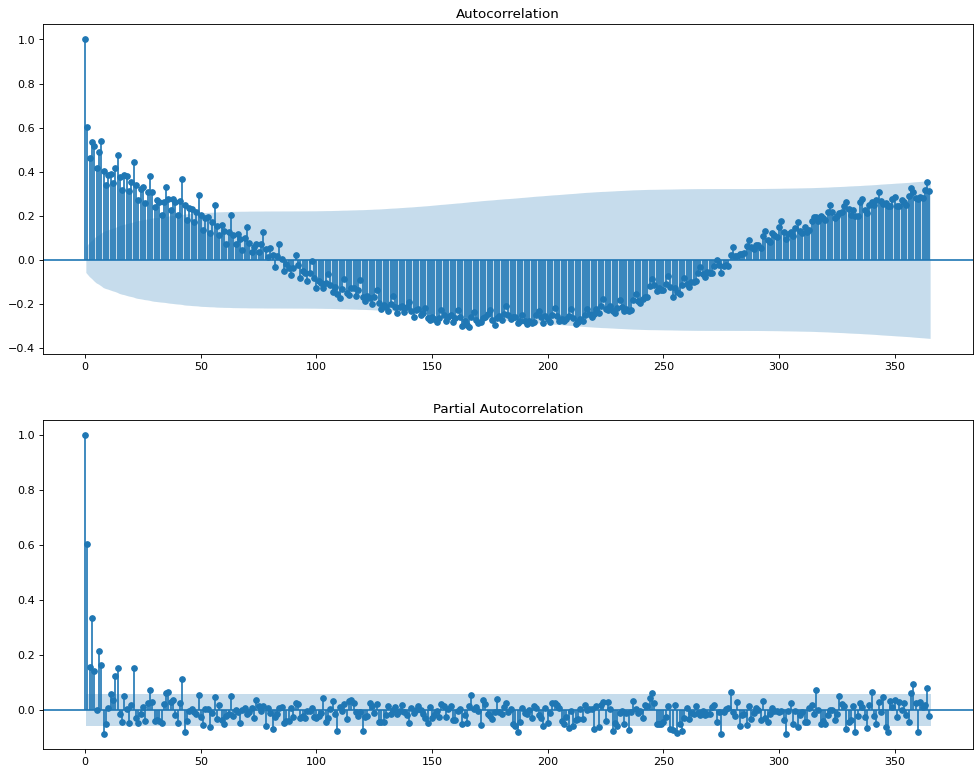

In [51]:
# plots
pyplot.figure(figsize=(15,12), dpi=80)
lags = 365
# acf
axis = pyplot.subplot(2, 1, 1)
plot_acf(series, ax=axis, lags=lags)
# pacf
axis = pyplot.subplot(2, 1, 2)
plot_pacf(series, ax=axis, lags=lags)
# show plot
pyplot.show()

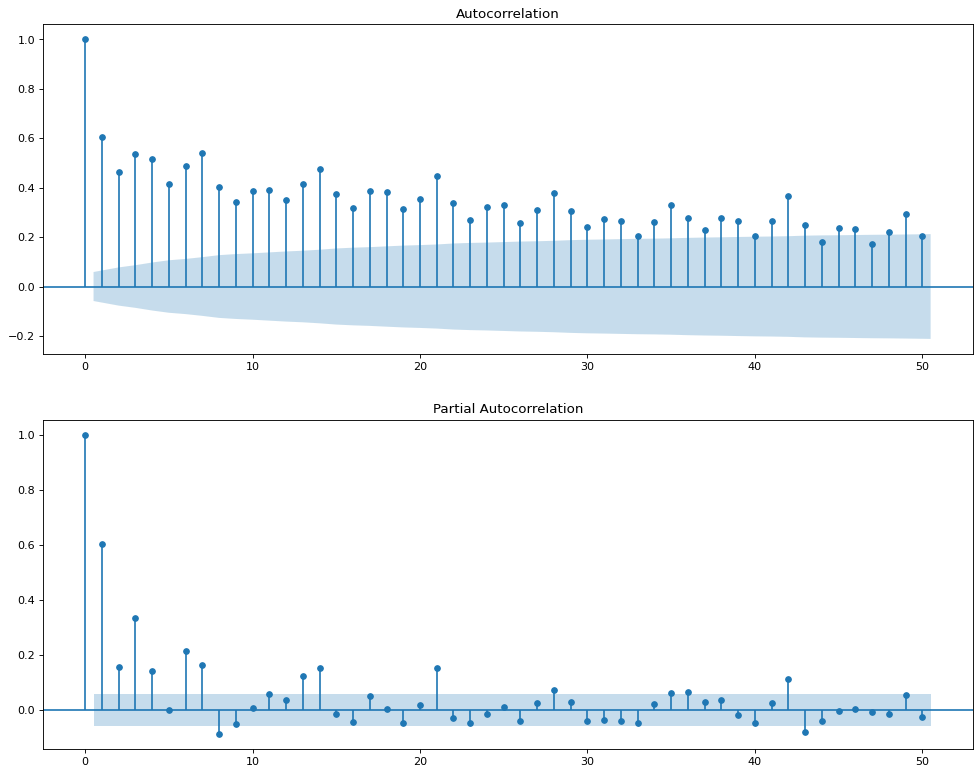

In [52]:
# plots8
pyplot.figure(figsize=(15,12), dpi=80)
lags = 50
# acf
axis = pyplot.subplot(2, 1, 1)
plot_acf(series, ax=axis, lags=lags)
# pacf
axis = pyplot.subplot(2, 1, 2)
plot_pacf(series, ax=axis, lags=lags)
# show plot
pyplot.show()

In [55]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

ARIMA permite facilmente implementar un promedio movible de los datos en el tiempo 
tenemos que ajustar los datos para que los convierta en una seria univariable por DIA
luego pasamos los 7 días al constructor de la clase ARIMA 

In [60]:
# arima forecast
def arima_forecast(history):
    # convert history into a univariate series
    series = to_series(history)
    # define the model
    model = ARIMA(series, order=(7,0,0))
    # fit the model
    model_fit = model.fit(disp=False)
    # make forecast
    yhat = model_fit.predict(len(series), len(series)+6)
    return yhat

In [61]:
models = dict()
models['arima'] = arima_forecast
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.figure(figsize=(15,12), dpi=0)
for name, func in models.items():
    # evaluate and get scores
    score, scores = evaluate_model(func, train, test)
    # summarize scores
    summarize_scores(name, score, scores)
    # plot scores
    pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()

arima: [381.599] 393.8, 398.9, 356.9, 377.1, 393.8, 306.0, 432.2


ValueError: cannot convert float NaN to integer